In [6]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error

In [4]:
#df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
#df.to_parquet('green_tripdata_2021-01.parquet')

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")


<Experiment: artifact_location='file:///c:/Users/Marcelo/Documents/mlops-zoomcamp/01-intro/mlruns/1', creation_time=1747074086533, experiment_id='1', last_update_time=1747074086533, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829623

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [21]:
train_data_path = 'green_tripdata_2021-01.parquet'
val_data_path = 'green_tripdata_2021-02.parquet'

In [22]:
df_train = read_dataframe(train_data_path)
df_val = read_dataframe(val_data_path)

In [11]:
len(df_train),len(df_val)

(73908, 61921)

In [12]:
train_dicts = df[categorical+numerical].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [14]:
target = 'duration'
y_train = df[target].values

In [15]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [16]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=21, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=21, random_state=42)

In [52]:
y_pred = rf_regressor.predict(X_train)

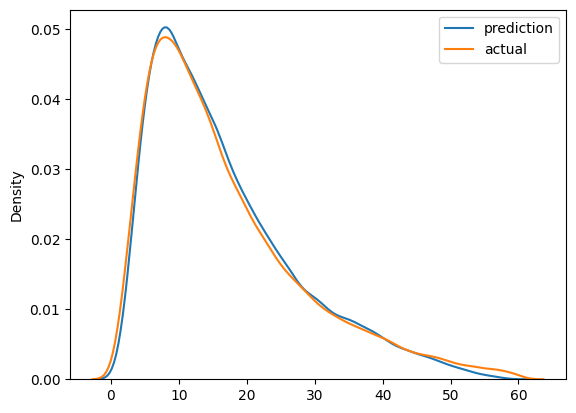

In [54]:
#plt.figure(figsize=(10, 6))
sns.kdeplot(data=y_pred, label='prediction')
sns.kdeplot(data=y_train, label='actual')
plt.legend()
plt.show()

In [55]:
root_mean_squared_error(y_train,y_pred)

2.410136913484347

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [24]:
#rf_regressor = RandomForestRegressor(n_estimators=21, random_state=42)
#rf_regressor.fit(X_train, y_train)
with mlflow.start_run():
    mlflow.set_tag("developer", "marcelo")
    mlflow.log_param("train-data-path", train_data_path)
    mlflow.log_param("valid-data-path", val_data_path)
    alpha = 0.001
    mlflow.log_param("model", "lasso")
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metrics({"rmse": rmse})
    mlflow.log_params({"alpha": alpha})
    

In [69]:

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.75871521021275

In [63]:
import pickle

In [64]:
dv

DictVectorizer()

In [68]:
with open('models/lr_regressor.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)